In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)

In [2]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

***
## load models

In [3]:
files = glob("../input/ump-artifacts/lgbm-linear-dart/lgbm-seed*.txt")
display(files)

boosters_lgbm_linear_dart = [lgb.Booster(model_file=fn) for fn in files]
display(boosters_lgbm_linear_dart)

['../input/ump-artifacts/lgbm-linear-dart/lgbm-seed2.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed19.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed23.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed7.txt',
 '../input/ump-artifacts/lgbm-linear-dart/lgbm-seed11.txt']

***
## model retrain/finetuning on newest data

In [4]:
feat_names = [f"f_{i}" for i in range(300)]
col_names = feat_names + ["target"]

supp_data = pd.read_csv("../input/ubiquant-market-prediction/supplemental_train.csv", usecols=col_names)
supp_data = reduce_mem_usage(supp_data, verbose=True)
gc.collect()

Mem. usage decreased to 1082.73 Mb (50.0% reduction)


30

In [5]:
train_dset = lgb.Dataset(
    data=supp_data[feat_names],
    label=supp_data["target"].values,
    free_raw_data=False,
)
del supp_data
gc.collect()

0

In [6]:
# same params used for training, except num_iteration (was lowered 1900->450) and max_drop was increased (5->20)
model_params = {
    'boosting': 'dart',
    'linear_tree': True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'max_bin': 511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 1.0,
    'drop_rate': 0.05,
    'feature_fraction': 0.15000000000000002,
    'lambda_l1': 3.2608153782775893,
    'lambda_l2': 24.65715474841406,
    'linear_lambda': 15.831719022196562,
    'max_drop': 20,
    'min_data_in_leaf': 2200,
    'num_iterations': 1,
    'path_smooth': 4.714076496843463,
    'skip_drop': 0.65
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


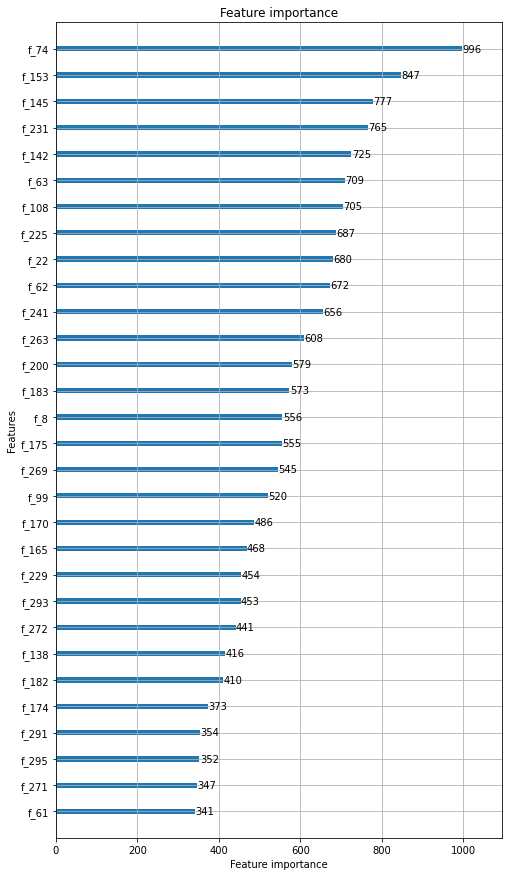

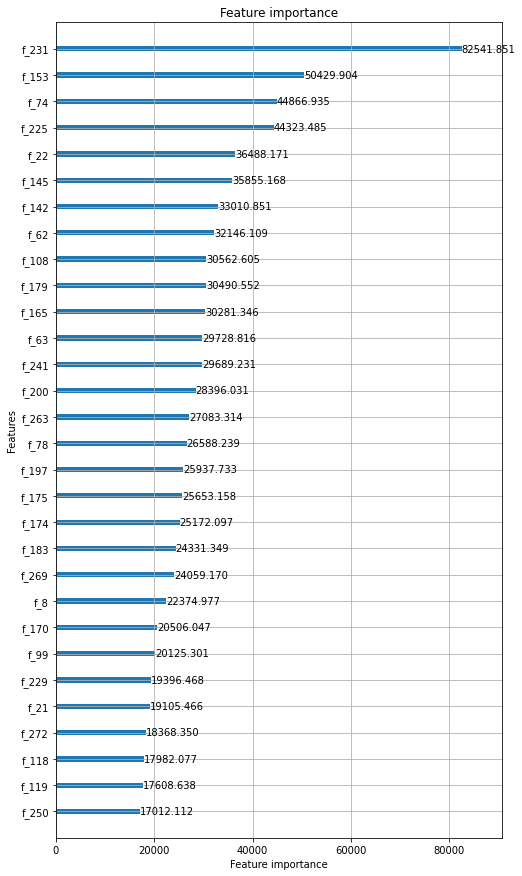

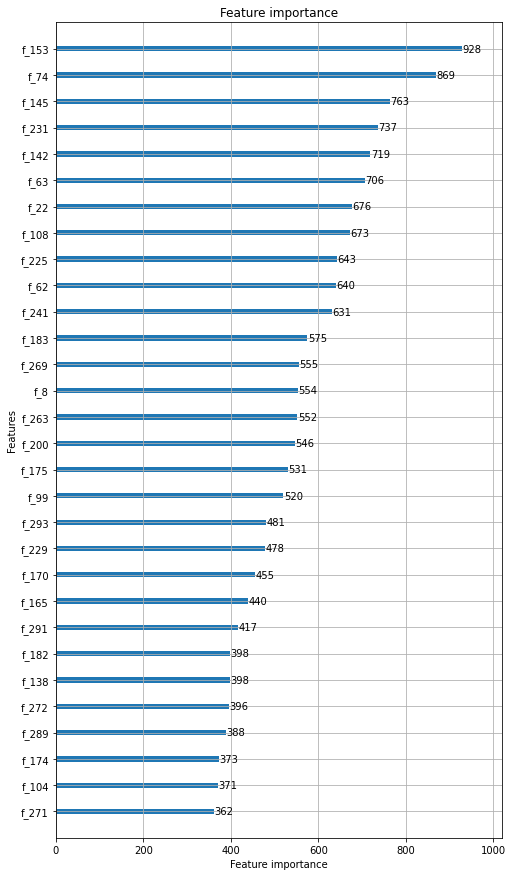

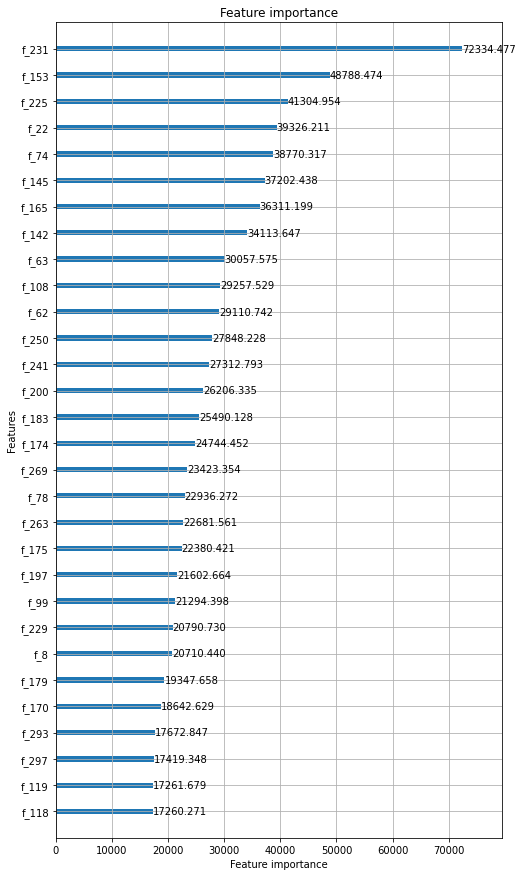

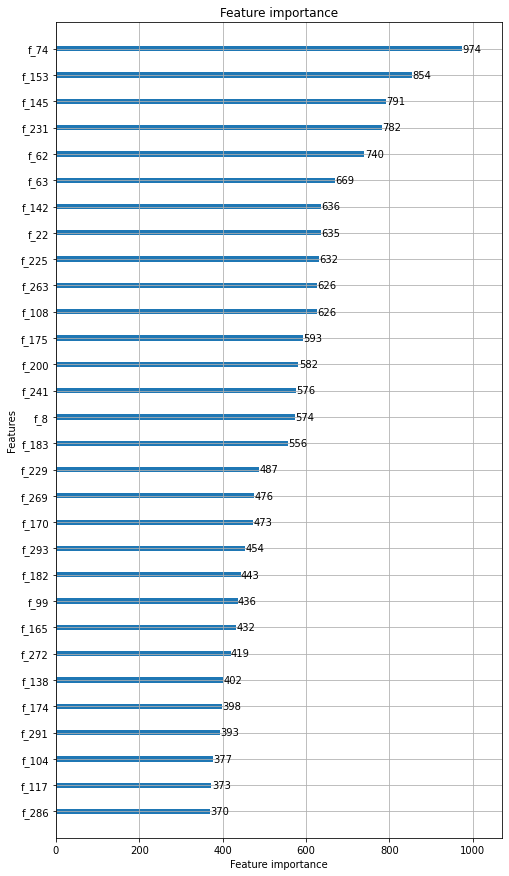

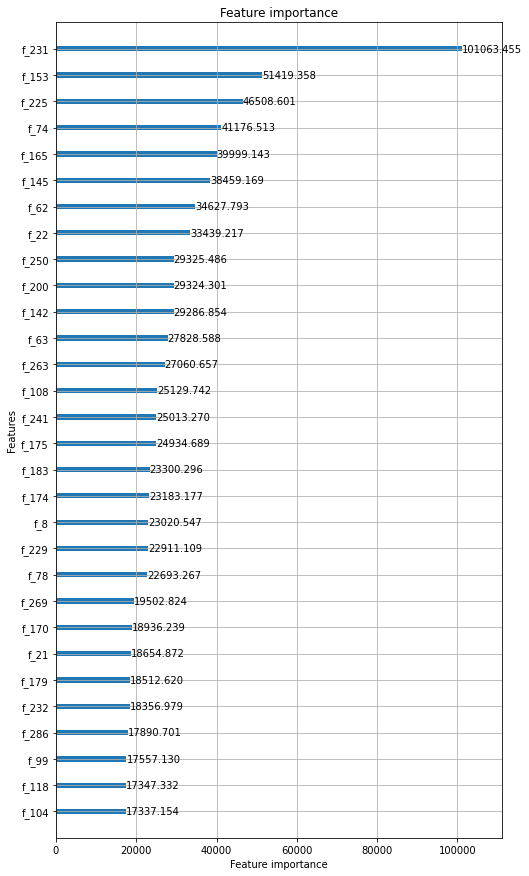

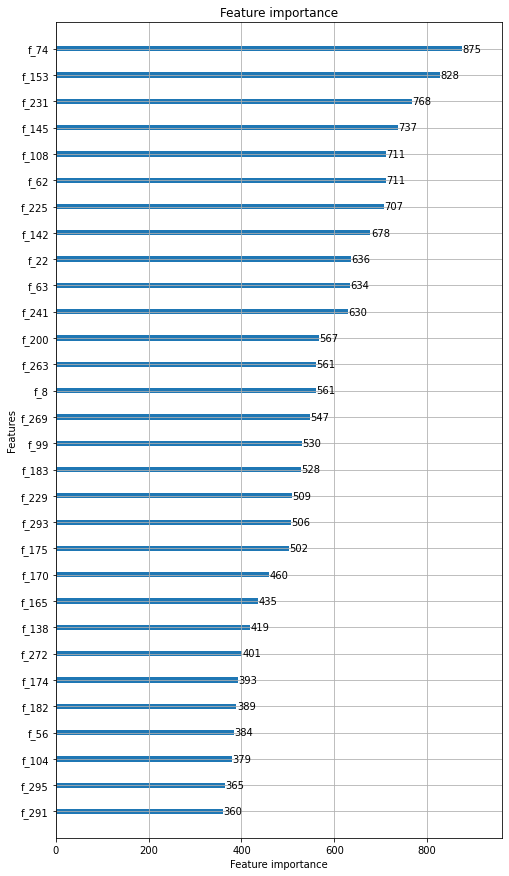

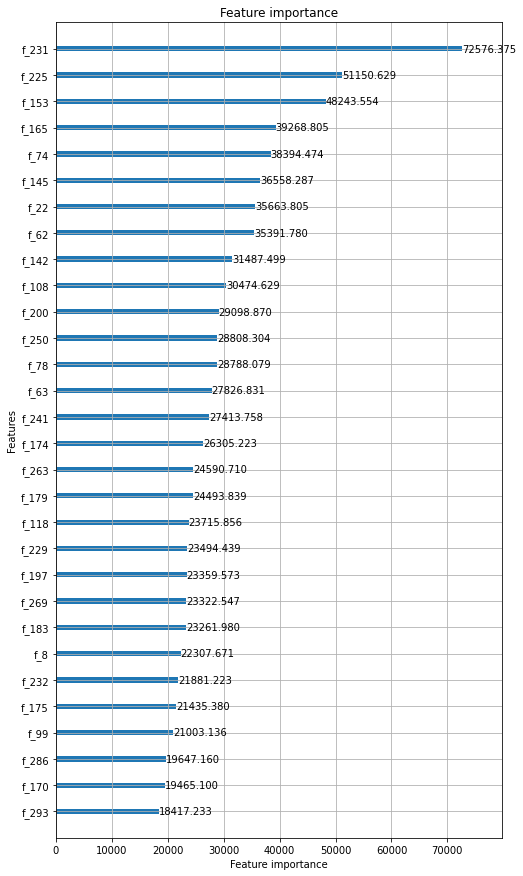

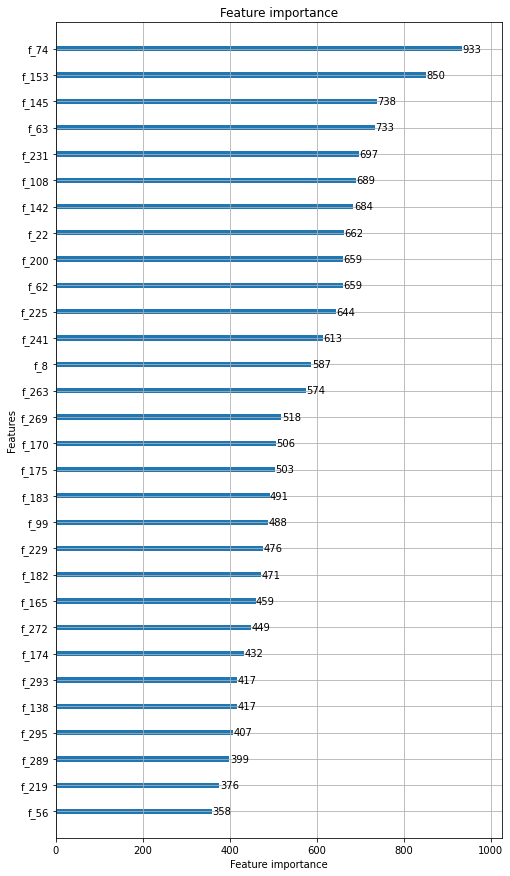

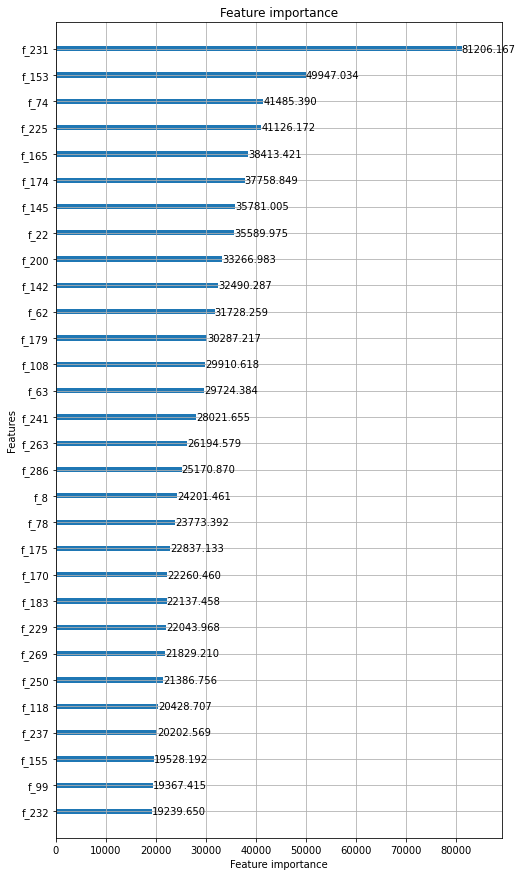

In [7]:
seeds = [2,7,11,19,23]
finetuned_models = list()

for seed,base_model in zip(seeds, boosters_lgbm_linear_dart):
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    log_callback = lgb.log_evaluation(period=20)
    
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[log_callback,],
        init_model=base_model,
    )
    finetuned_models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [8]:
del train_dset, boosters_lgbm_linear_dart
gc.collect()

16996

***
## inference

In [9]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

In [10]:
def predict(boosters, dataframe ):
    features = [f"f_{i}" for i in range(300)]
    preds = [
        model.predict(
            dataframe[features],
            start_iteration=0,
            num_iteration=model.current_iteration(),
        ) 
        for model in boosters
    ]
    return np.mean(preds, axis=0)

In [11]:
for (test_df, sample_prediction_df) in iter_test:  
    predictions = predict(finetuned_models, test_df)
    sample_prediction_df['target'] = predictions
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,row_id,target
0,1220_1,-0.120322
1,1220_2,-0.056959


,row_id,target
0,1221_0,-0.087601
1,1221_1,-0.105265
2,1221_2,-0.097735


,row_id,target
0,1222_0,-0.044794
1,1222_1,-0.075646
2,1222_2,-0.086897


,row_id,target
0,1223_0,-0.069414


***